<a href="https://www.kaggle.com/code/osmanacar/diabetes-eda-ml-prediction?scriptVersionId=207277294" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Business Problem**

It is desired to develop a machine learning model that can predict the components of a diabetic patient.

**Dataset Story**

Dataset is the part of National Institutes of Diabetes-Digestive-Kidney Diseases at USA.

Data used for a diabetes study conducted on Pima Indian women aged 21 and over living in the city of Phoenix.

Target variable is "outcome" and it's define as 1 is diabetes positive 0 is negative

**Variables**

* Pregnancies: Pregnant count
* Glucose: 2-hour plasma glucose concentration in the oral glucose tolerance test
* Blood Pressure: Blood Pressure (Diabetes) (mmHg
* SkinThickness: Skin Thickness
* Insulin: 2-hour serum insulin (mu U/ml)
* DiabetesPedigreeFunction :  Function (2-hour plasma glucose concentration in oral glucose tolerance test) (Probably family history)
* BMI: Body mass index
* Age: Age(year)
* Outcome: Have the disease (1) or not (0)

In [1]:
# Importing library and read the dataset
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay


pd.set_option("display.max_columns", None)
pd.set_option("display.max_row", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width", 500)

df = pd.read_csv("/kaggle/input/diabetes/diabetes.csv")

# **Data Analysis and Preparing**

In [2]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [3]:
print(f"Observation: {df.shape[0]} / Variable: {df.shape[1]}")

Observation: 768 / Variable: 9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
df.describe().T
# Some variables min value is 0. This is impossible. We will see on next steps they have missing value

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [7]:
# Checking categorical and numerical variables
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if
                   dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [8]:
print(f"Categorical: {cat_cols}")
print(f"Numerical: {num_cols}")

Categorical: ['Outcome']
Numerical: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896
##########################################


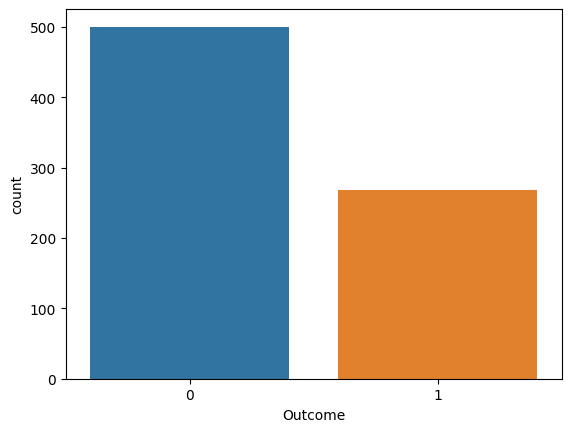

In [9]:
# Categorical variable analysis
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
        
for col in cat_cols:
    cat_summary(df, col, True)

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


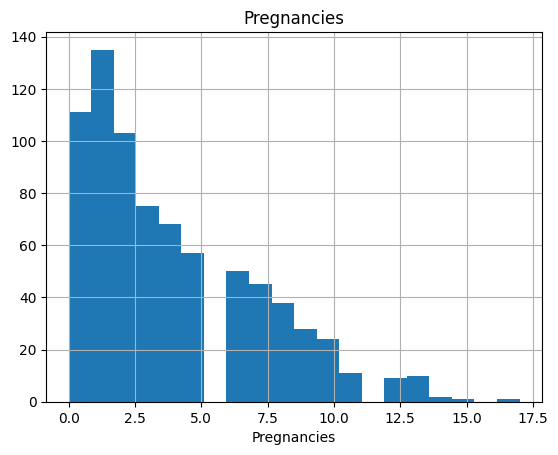

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


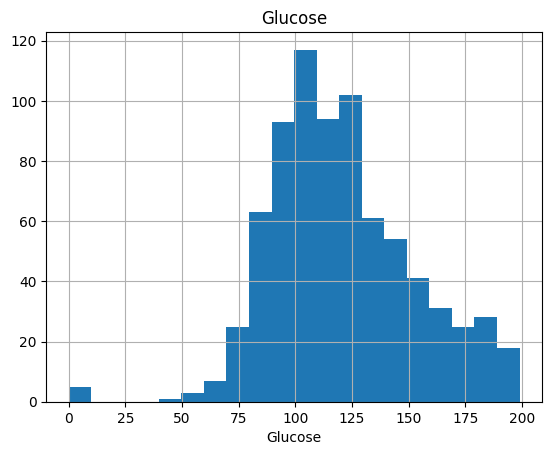

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


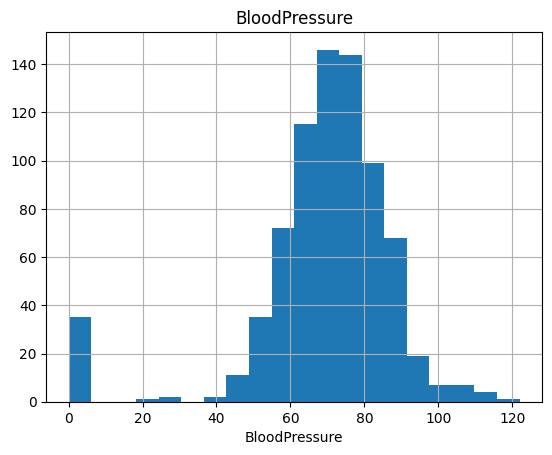

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


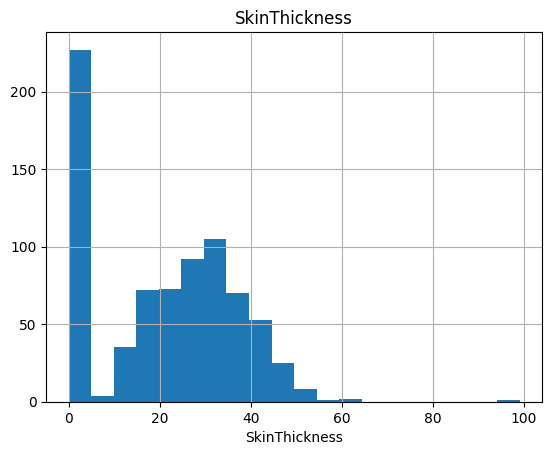

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


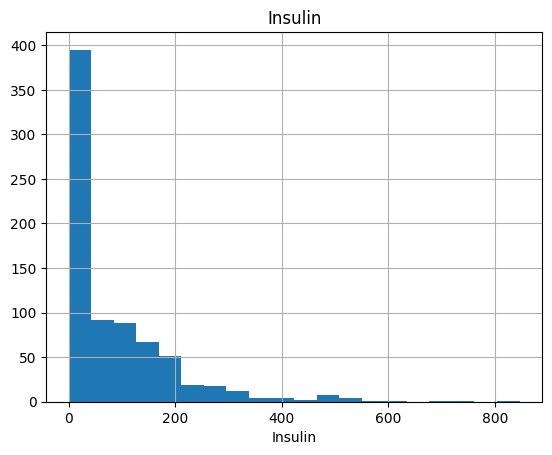

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


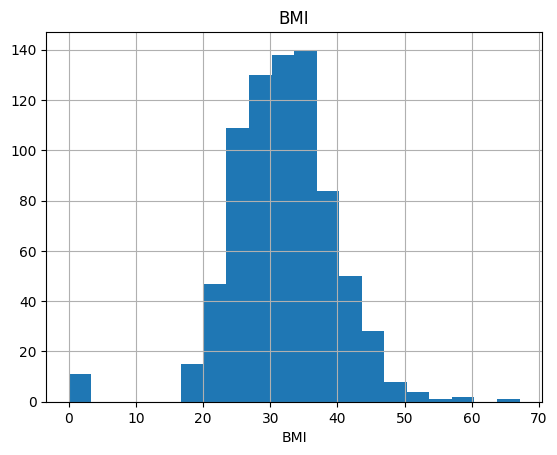

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


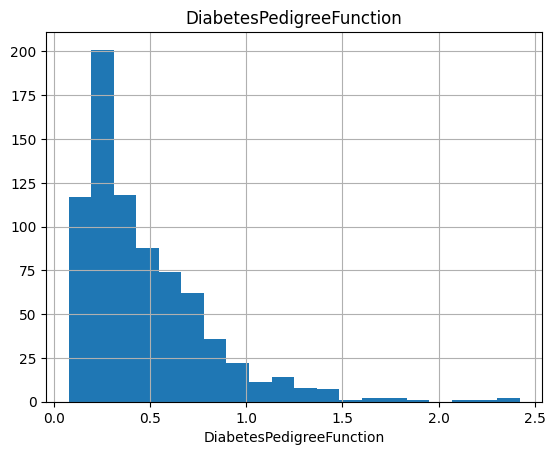

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


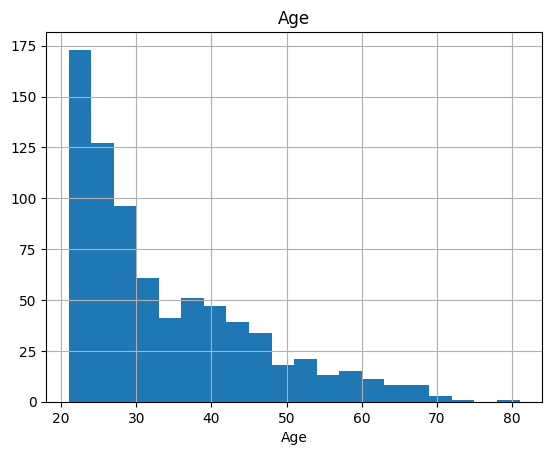

In [10]:
# Numerical variable analysis
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)


for col in num_cols:
    num_summary(df, col, plot=True)

         TARGET_MEAN
Outcome             
0              0.000
1              1.000




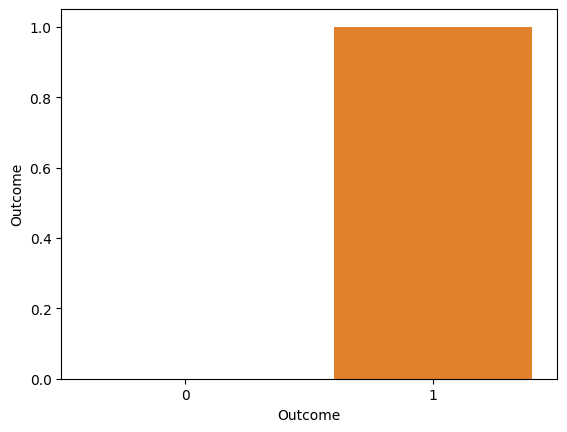

In [11]:
# Target variable analysis for Categorical - Target : Outcome
def target_summary_with_cat(dataframe, target, categorical_col, plot=False):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")
    if plot:
        sns.barplot(x=categorical_col, y=target, data=dataframe)
        plt.show(block=True)


for col in cat_cols:
    target_summary_with_cat(df, "Outcome", col, plot=True)

         Pregnancies
Outcome             
0              3.298
1              4.866




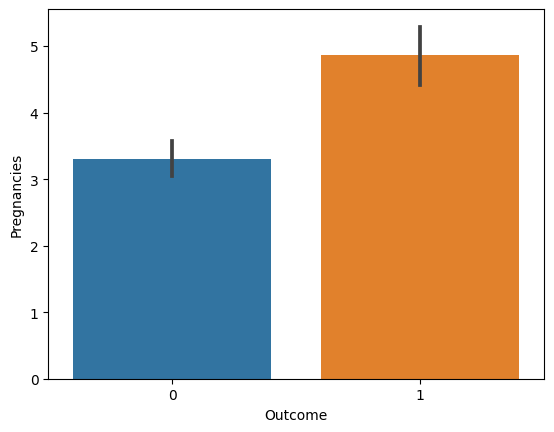

         Glucose
Outcome         
0        109.980
1        141.257




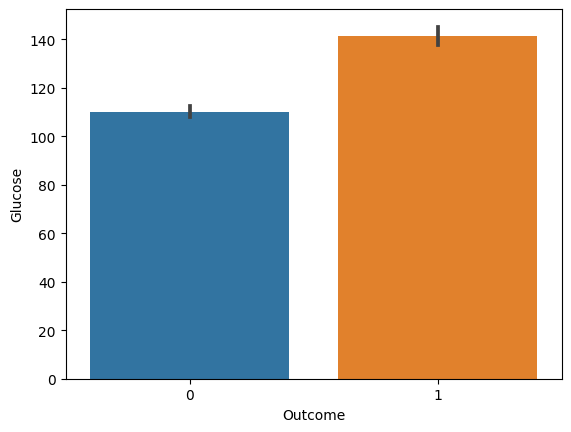

         BloodPressure
Outcome               
0               68.184
1               70.825




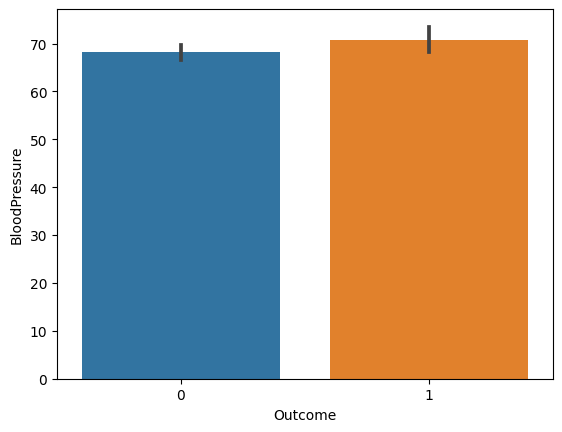

         SkinThickness
Outcome               
0               19.664
1               22.164




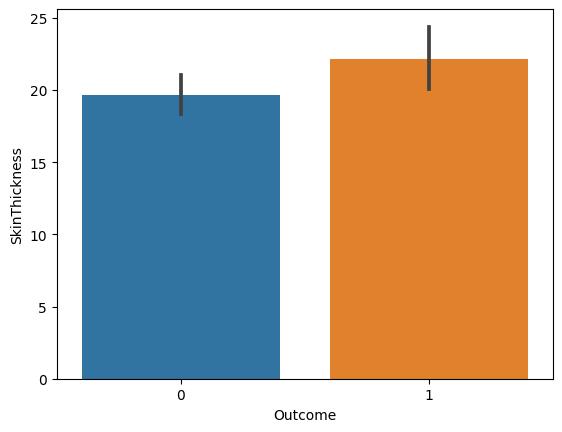

         Insulin
Outcome         
0         68.792
1        100.336




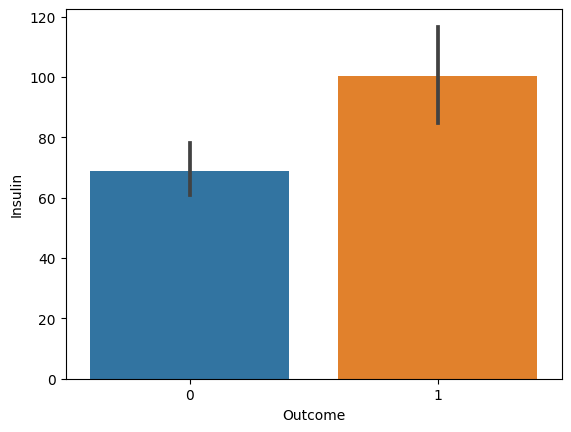

           BMI
Outcome       
0       30.304
1       35.143




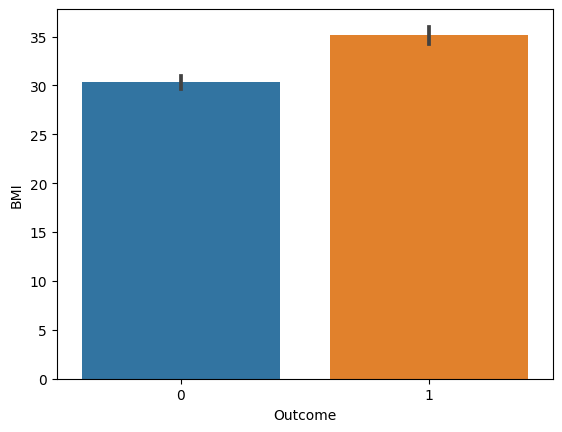

         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550




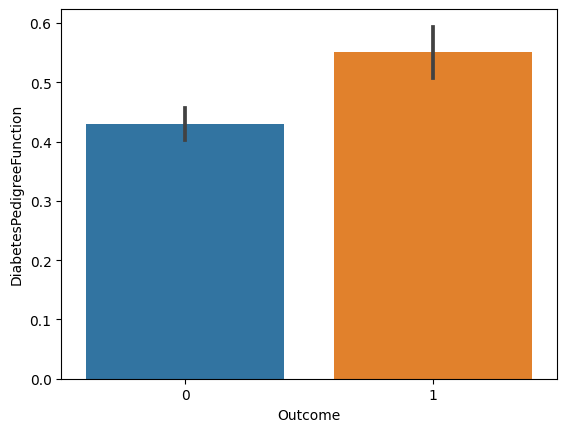

           Age
Outcome       
0       31.190
1       37.067




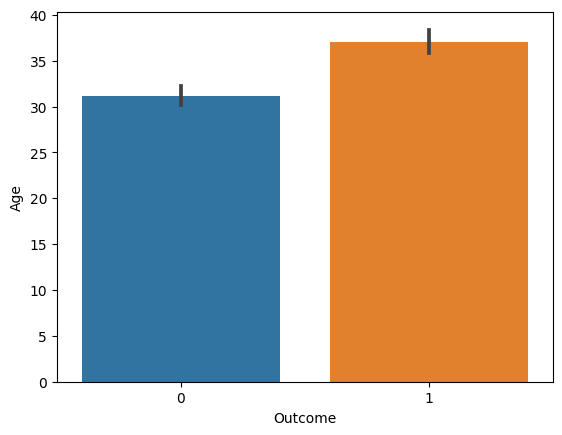

In [12]:
# Target variable analysis for Numerical - Target : Outcome
def target_summary_with_num(dataframe, target, numerical_col, plot=False):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")
    if plot:
        sns.barplot(x=target, y=numerical_col, data=dataframe)
        plt.show(block=True)


for col in num_cols:
    target_summary_with_num(df, "Outcome", col, plot=True)

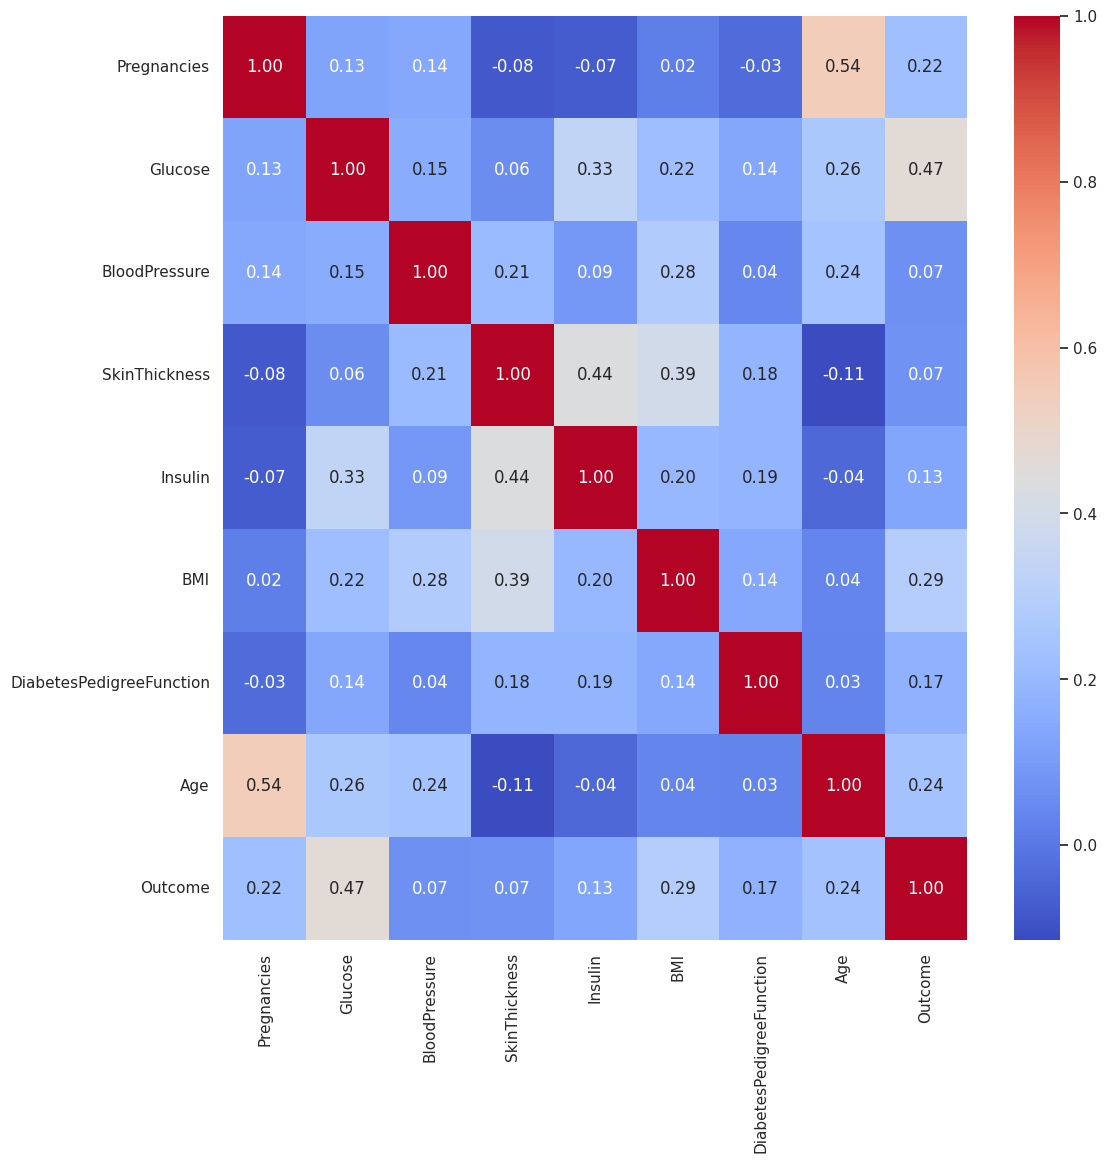

In [13]:
corr = df.corr()
sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f")
plt.show()

In [14]:
# Checking outliers
def outlier_threshold(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_threshold(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_threshold(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [15]:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies True
Glucose True
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True


In [16]:
for col in num_cols:
    replace_with_thresholds(df, col)

/tmp/ipykernel_18/4142071154.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-6.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
/tmp/ipykernel_18/4142071154.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '37.125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
/tmp/ipykernel_18/4142071154.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-190.875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
/

In [17]:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


In [18]:
# function for finding missing values
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [19]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [20]:
df = pd.read_csv("/kaggle/input/diabetes/diabetes.csv")

In [21]:
# Pregnancies should be 0 but others shouldn't.
missing_zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]
missing_zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [22]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [23]:
for col in missing_zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

missing_values_table(df)

# We found missing values. 

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


In [24]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [25]:
# Filling in the zeros with KNN method
fill_nan_data = df[missing_zero_columns]
knnimputer = KNNImputer(n_neighbors=5)
df[missing_zero_columns] = knnimputer.fit_transform(fill_nan_data)

In [26]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

# **Feature Engineering**

In [27]:
df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "middleage"
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "oldperson"
df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],
                       labels=["Underweight", "Healthy", "Overweight", "Obese"])
df["NEW_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0, 70, 140, 300], labels=["Normal", "Prediabetes", "Diabetes"])
df["NEW_INSULIN"] = pd.cut(x=df["Insulin"], bins=[0, 16, 166, 300, 500, 1000],
                           labels=["low", "medium", "High", "UpperHigh", "ProbablyDie"])

df["NEW_PREGNANCY_AGE"] = np.where(df["Pregnancies"] != 0, df["Age"] / df["Pregnancies"], 0)
df["NEW_PREGNANCY_PEDIGREE"] = df["Pregnancies"] * df["DiabetesPedigreeFunction"]
df["NEW_PREGNANCY_INSULIN"] = np.where(df["Pregnancies"] != 0, df["Pregnancies"] / df['Insulin'], 0)
df["NEW_GLUCOSE_INSULIN"] = df['Glucose'] / df['Insulin']
df["NEW_BLOOD_SKIN"] = df["SkinThickness"] / df["BloodPressure"]
df["NEW_PEDIGREE_AGE"] = df["Age"] / df["DiabetesPedigreeFunction"]
df["NEW_AGE_SKIN_THICKNESS"] = df["Age"] / df["SkinThickness"]
df["NEW_AGE_BLOOD_PRESSURE"] = df["Age"] / df["BloodPressure"]
df["NEW_AGE_BMI"] = df["Age"] / df["BMI"]
df["NEW_AGE_INSULIN"] = df["Age"] / df["Insulin"]
df["NEW_AGE_GLUCOSE"] = df["Age"] / df["Glucose"]
df["NEW_BMI_PREG"] = df["Pregnancies"] * df["BMI"]
df["NEW_BMI_INSULIN"] = df["BMI"] / df["Insulin"]
df["NEW_BMI_GLUCOSE"] = df["BMI"] / df["Glucose"]
df["NEW_BMI_BLOOD_PRESSURE"] = df["BMI"] / df["BloodPressure"]
df["NEW_BMI_SKIN_THICKNESS"] = df["BMI"] / df["SkinThickness"]
df["NEW_INSULIN_BLOOD_PRESSURE"] = df["BloodPressure"] / df["Insulin"]
df["NEW_GLUCOSE_BLOOD_PRESSURE"] = df["BloodPressure"] / df["Glucose"]

In [28]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
cat_cols = [col for col in cat_cols if col not in ["Outcome"]]

Observations: 768
Variables: 31
cat_cols: 5
num_cols: 26
cat_but_car: 0
num_but_cat: 4


In [29]:
def label_encoder(dataframe, cols):
    labelEncoder = LabelEncoder()
    dataframe[cols] = labelEncoder.fit_transform(dataframe[cols])
    return dataframe

for col in cat_cols:
    df = label_encoder(df, col)

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_INSULIN,NEW_PREGNANCY_AGE,NEW_PREGNANCY_PEDIGREE,NEW_PREGNANCY_INSULIN,NEW_GLUCOSE_INSULIN,NEW_BLOOD_SKIN,NEW_PEDIGREE_AGE,NEW_AGE_SKIN_THICKNESS,NEW_AGE_BLOOD_PRESSURE,NEW_AGE_BMI,NEW_AGE_INSULIN,NEW_AGE_GLUCOSE,NEW_BMI_PREG,NEW_BMI_INSULIN,NEW_BMI_GLUCOSE,NEW_BMI_BLOOD_PRESSURE,NEW_BMI_SKIN_THICKNESS,NEW_INSULIN_BLOOD_PRESSURE,NEW_GLUCOSE_BLOOD_PRESSURE
0,6,148.000,72.000,35.000,209.000,33.600,0.627,50,1,1,1,0,0,8.333,3.762,0.029,0.708,0.486,79.745,1.429,0.694,1.488,0.239,0.338,201.600,0.161,0.227,0.467,0.960,0.344,0.486
1,1,85.000,66.000,29.000,73.000,26.600,0.351,31,0,0,2,2,4,31.000,0.351,0.014,1.164,0.439,88.319,1.069,0.470,1.165,0.425,0.365,26.600,0.364,0.313,0.403,0.917,0.904,0.776
2,8,183.000,64.000,29.400,383.200,23.300,0.672,32,1,0,0,0,2,4.000,5.376,0.021,0.478,0.459,47.619,1.088,0.500,1.373,0.084,0.175,186.400,0.061,0.127,0.364,0.793,0.167,0.350
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,2,2,4,21.000,0.167,0.011,0.947,0.348,125.749,0.913,0.318,0.747,0.223,0.236,28.100,0.299,0.316,0.426,1.222,0.702,0.742
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,1,2,0,0.000,0.000,0.000,0.815,0.875,14.423,0.943,0.825,0.766,0.196,0.241,0.000,0.257,0.315,1.078,1.231,0.238,0.292


In [30]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols)

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_PREGNANCY_AGE,NEW_PREGNANCY_PEDIGREE,NEW_PREGNANCY_INSULIN,NEW_GLUCOSE_INSULIN,NEW_BLOOD_SKIN,NEW_PEDIGREE_AGE,NEW_AGE_SKIN_THICKNESS,NEW_AGE_BLOOD_PRESSURE,NEW_AGE_BMI,NEW_AGE_INSULIN,NEW_AGE_GLUCOSE,NEW_BMI_PREG,NEW_BMI_INSULIN,NEW_BMI_GLUCOSE,NEW_BMI_BLOOD_PRESSURE,NEW_BMI_SKIN_THICKNESS,NEW_INSULIN_BLOOD_PRESSURE,NEW_GLUCOSE_BLOOD_PRESSURE,NEW_AGE_CAT_1,NEW_BMI_1,NEW_BMI_2,NEW_BMI_3,NEW_GLUCOSE_1,NEW_GLUCOSE_2,NEW_INSULIN_1,NEW_INSULIN_2,NEW_INSULIN_3,NEW_INSULIN_4
0,6,148.000,72.000,35.000,209.000,33.600,0.627,50,1,8.333,3.762,0.029,0.708,0.486,79.745,1.429,0.694,1.488,0.239,0.338,201.600,0.161,0.227,0.467,0.960,0.344,0.486,True,True,False,False,False,False,False,False,False,False
1,1,85.000,66.000,29.000,73.000,26.600,0.351,31,0,31.000,0.351,0.014,1.164,0.439,88.319,1.069,0.470,1.165,0.425,0.365,26.600,0.364,0.313,0.403,0.917,0.904,0.776,False,False,True,False,False,True,False,False,False,True
2,8,183.000,64.000,29.400,383.200,23.300,0.672,32,1,4.000,5.376,0.021,0.478,0.459,47.619,1.088,0.500,1.373,0.084,0.175,186.400,0.061,0.127,0.364,0.793,0.167,0.350,False,False,False,False,False,False,False,True,False,False
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,21.000,0.167,0.011,0.947,0.348,125.749,0.913,0.318,0.747,0.223,0.236,28.100,0.299,0.316,0.426,1.222,0.702,0.742,False,False,True,False,False,True,False,False,False,True
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0.000,0.000,0.000,0.815,0.875,14.423,0.943,0.825,0.766,0.196,0.241,0.000,0.257,0.315,1.078,1.231,0.238,0.292,False,True,False,False,False,True,False,False,False,False


In [31]:
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_PREGNANCY_AGE,NEW_PREGNANCY_PEDIGREE,NEW_PREGNANCY_INSULIN,NEW_GLUCOSE_INSULIN,NEW_BLOOD_SKIN,NEW_PEDIGREE_AGE,NEW_AGE_SKIN_THICKNESS,NEW_AGE_BLOOD_PRESSURE,NEW_AGE_BMI,NEW_AGE_INSULIN,NEW_AGE_GLUCOSE,NEW_BMI_PREG,NEW_BMI_INSULIN,NEW_BMI_GLUCOSE,NEW_BMI_BLOOD_PRESSURE,NEW_BMI_SKIN_THICKNESS,NEW_INSULIN_BLOOD_PRESSURE,NEW_GLUCOSE_BLOOD_PRESSURE,NEW_AGE_CAT_1,NEW_BMI_1,NEW_BMI_2,NEW_BMI_3,NEW_GLUCOSE_1,NEW_GLUCOSE_2,NEW_INSULIN_1,NEW_INSULIN_2,NEW_INSULIN_3,NEW_INSULIN_4
0,0.353,0.671,0.490,0.304,0.234,0.315,0.234,0.483,1,0.134,0.246,0.064,0.040,0.306,0.131,0.126,0.440,0.336,0.115,0.213,0.290,0.030,0.191,0.172,0.170,0.050,0.175,True,True,False,False,False,False,False,False,False,False
1,0.059,0.265,0.429,0.239,0.071,0.172,0.117,0.167,0,0.500,0.023,0.031,0.076,0.271,0.147,0.082,0.232,0.238,0.219,0.239,0.038,0.078,0.346,0.133,0.158,0.151,0.398,False,False,True,False,False,True,False,False,False,True
2,0.471,0.897,0.408,0.243,0.444,0.104,0.254,0.183,1,0.065,0.352,0.047,0.021,0.286,0.070,0.085,0.260,0.301,0.028,0.060,0.268,0.006,0.011,0.109,0.123,0.017,0.070,False,False,False,False,False,False,False,True,False,False
3,0.059,0.290,0.429,0.174,0.096,0.202,0.038,0.000,0,0.339,0.011,0.024,0.059,0.203,0.217,0.063,0.092,0.110,0.106,0.118,0.040,0.063,0.351,0.147,0.243,0.115,0.371,False,False,True,False,False,True,False,False,False,True
4,0.000,0.600,0.163,0.304,0.185,0.509,0.944,0.200,1,0.000,0.000,0.000,0.048,0.596,0.008,0.067,0.561,0.116,0.091,0.122,0.000,0.053,0.349,0.542,0.245,0.030,0.025,False,True,False,False,False,True,False,False,False,False


# **Modelling - Random Forest**

In [32]:
# Bagimli degisken
y = df["Outcome"]
# Bagimsiz degisken
X = df.drop(["Outcome"], axis=1)
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NEW_PREGNANCY_AGE,NEW_PREGNANCY_PEDIGREE,NEW_PREGNANCY_INSULIN,NEW_GLUCOSE_INSULIN,NEW_BLOOD_SKIN,NEW_PEDIGREE_AGE,NEW_AGE_SKIN_THICKNESS,NEW_AGE_BLOOD_PRESSURE,NEW_AGE_BMI,NEW_AGE_INSULIN,NEW_AGE_GLUCOSE,NEW_BMI_PREG,NEW_BMI_INSULIN,NEW_BMI_GLUCOSE,NEW_BMI_BLOOD_PRESSURE,NEW_BMI_SKIN_THICKNESS,NEW_INSULIN_BLOOD_PRESSURE,NEW_GLUCOSE_BLOOD_PRESSURE,NEW_AGE_CAT_1,NEW_BMI_1,NEW_BMI_2,NEW_BMI_3,NEW_GLUCOSE_1,NEW_GLUCOSE_2,NEW_INSULIN_1,NEW_INSULIN_2,NEW_INSULIN_3,NEW_INSULIN_4
0,0.353,0.671,0.490,0.304,0.234,0.315,0.234,0.483,0.134,0.246,0.064,0.040,0.306,0.131,0.126,0.440,0.336,0.115,0.213,0.290,0.030,0.191,0.172,0.170,0.050,0.175,True,True,False,False,False,False,False,False,False,False
1,0.059,0.265,0.429,0.239,0.071,0.172,0.117,0.167,0.500,0.023,0.031,0.076,0.271,0.147,0.082,0.232,0.238,0.219,0.239,0.038,0.078,0.346,0.133,0.158,0.151,0.398,False,False,True,False,False,True,False,False,False,True
2,0.471,0.897,0.408,0.243,0.444,0.104,0.254,0.183,0.065,0.352,0.047,0.021,0.286,0.070,0.085,0.260,0.301,0.028,0.060,0.268,0.006,0.011,0.109,0.123,0.017,0.070,False,False,False,False,False,False,False,True,False,False
3,0.059,0.290,0.429,0.174,0.096,0.202,0.038,0.000,0.339,0.011,0.024,0.059,0.203,0.217,0.063,0.092,0.110,0.106,0.118,0.040,0.063,0.351,0.147,0.243,0.115,0.371,False,False,True,False,False,True,False,False,False,True
4,0.000,0.600,0.163,0.304,0.185,0.509,0.944,0.200,0.000,0.000,0.000,0.048,0.596,0.008,0.067,0.561,0.116,0.091,0.122,0.000,0.053,0.349,0.542,0.245,0.030,0.025,False,True,False,False,False,True,False,False,False,False


In [33]:
# Egitim setinin train ve test olarak ayrilmasi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train,y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7708333333333334

In [34]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=[10, 10])
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])

    plt.title("Features")
    plt.tight_layout()
    plt.show()

    if save:
        plt.savefig("importances.png")

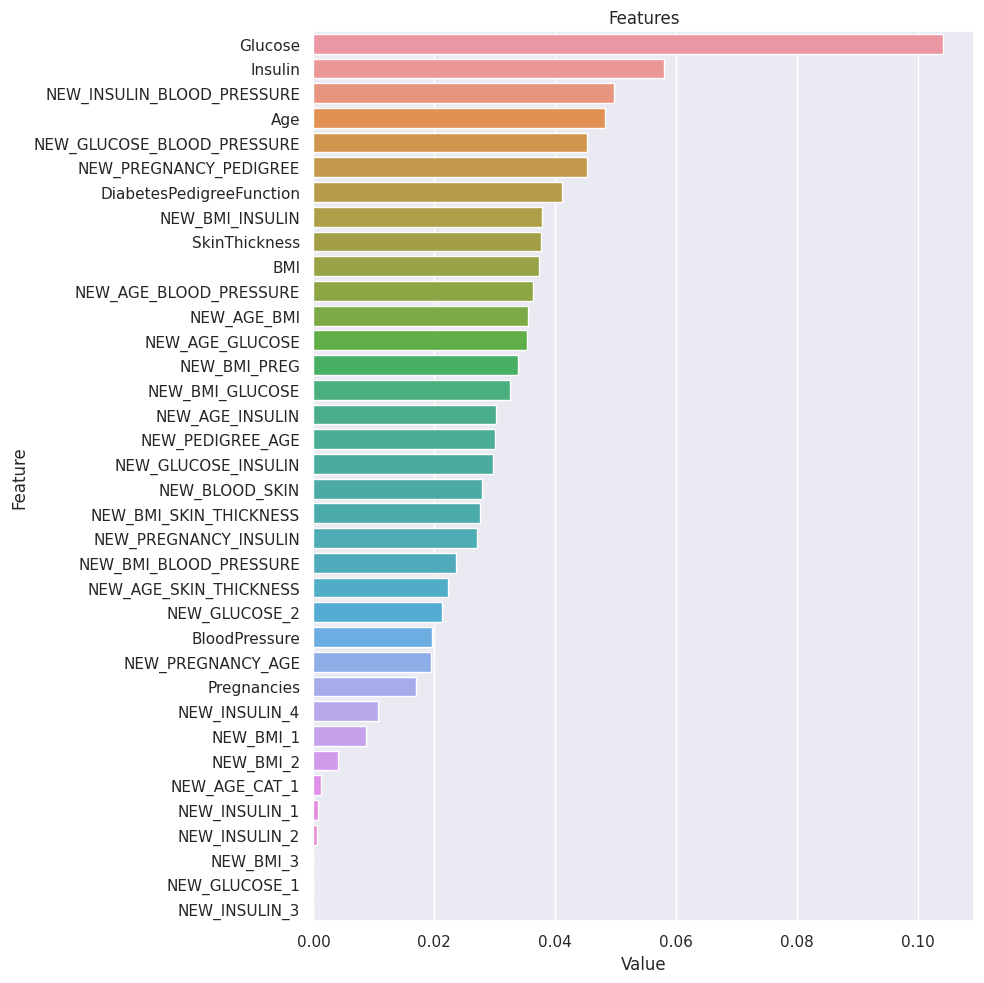

In [35]:
plot_importance(rf_model, X_train)

# **Modelling - Logistic Regression**

In [36]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

log_model = LogisticRegression().fit(X, y)
y_pred = log_model.predict(X)

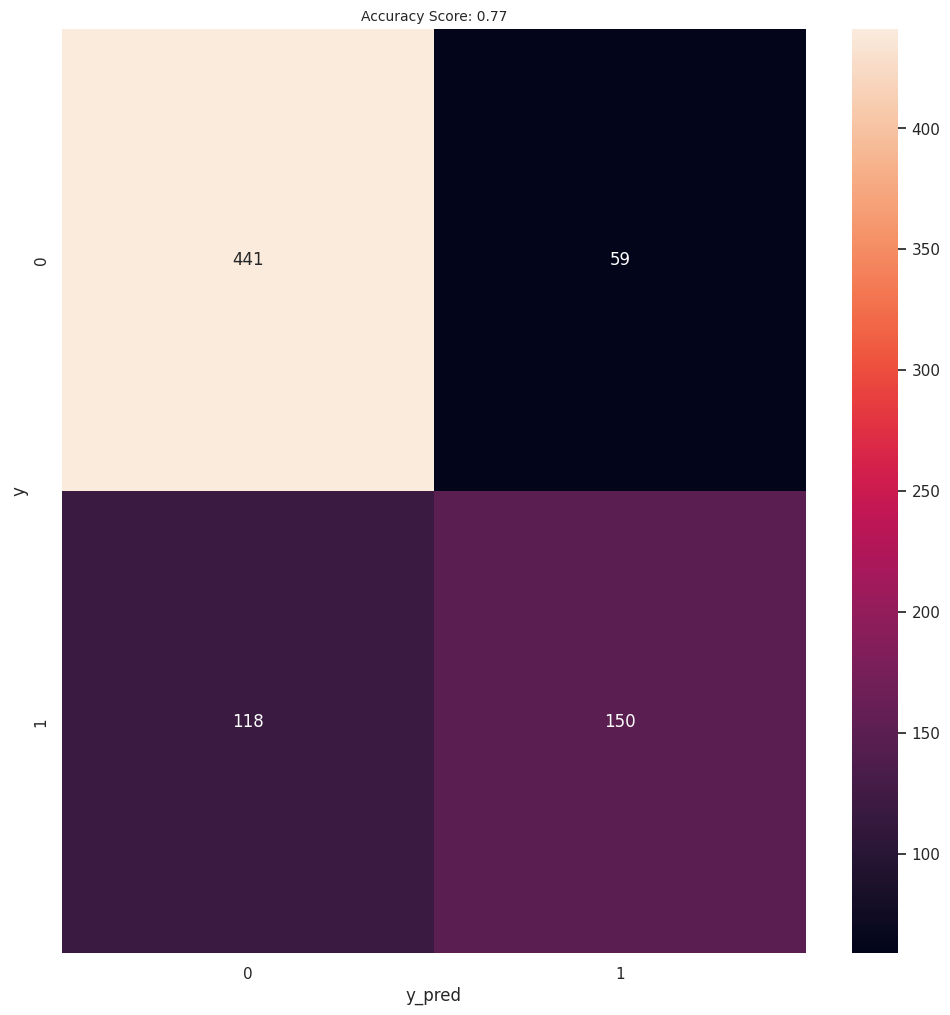

In [37]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel("y_pred")
    plt.ylabel("y")
    plt.title("Accuracy Score: {0}".format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred)

In [38]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       500
           1       0.72      0.56      0.63       268

    accuracy                           0.77       768
   macro avg       0.75      0.72      0.73       768
weighted avg       0.76      0.77      0.76       768



In [39]:
y_prob = log_model.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.8533208955223881

In [40]:
# Accuracy: 0.77
# Precision: 0.72
# Recall: 0.56
# F1-score: 0.63
# ROC AUC Score : 0.85

# **Model Validation - Hold Out**

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

log_model = LogisticRegression().fit(X_train, y_train)
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
roc_auc_score(y_test, y_prob)

              precision    recall  f1-score   support

           0       0.76      0.91      0.83        97
           1       0.76      0.51      0.61        57

    accuracy                           0.76       154
   macro avg       0.76      0.71      0.72       154
weighted avg       0.76      0.76      0.75       154



0.8724905046120456

In [42]:
# Accuracy: 0.76
# Precision: 0.76
# Recall: 0.51
# F1-score: 0.61 
# ROC AUC Score : 0.87

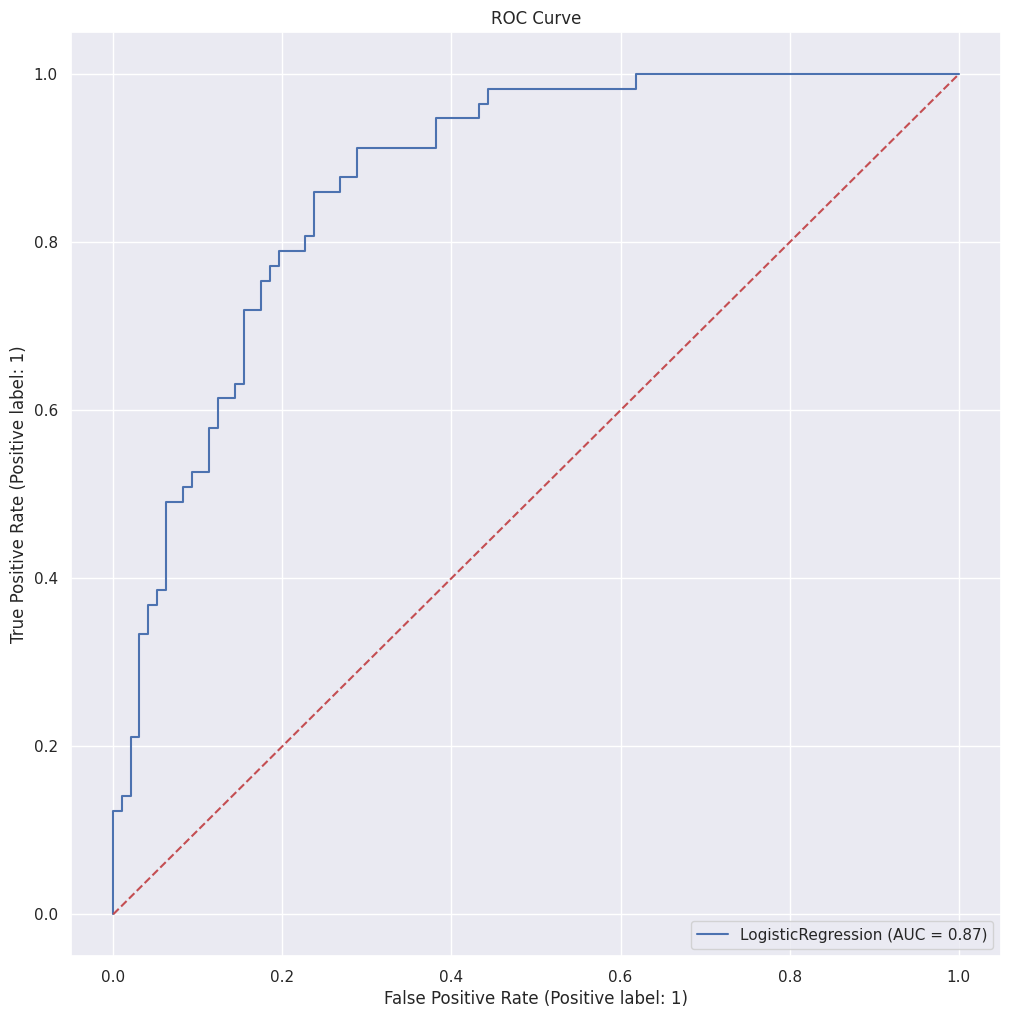

In [43]:
RocCurveDisplay.from_estimator(log_model, X_test, y_test)
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1], "r--")
plt.show()

# **Model Validation - 10 Fold Cross Validation**

In [44]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

log_model = LogisticRegression().fit(X, y)

cv_results = cross_validate(log_model, X, y, cv=5, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

print(cv_results["test_accuracy"].mean())
print(cv_results["test_precision"].mean())
print(cv_results["test_recall"].mean())
print(cv_results["test_f1"].mean())
print(cv_results["test_roc_auc"].mean())

0.764374840845429
0.7188077411892764
0.5449336128581412
0.6173851115625464
0.8399923130677849


In [45]:
# Accuracy: 0.76
# Precision: 0.71
# Recall: 0.54
# F1-score: 0.61 
# ROC AUC Score : 0.84